
Create an RHI plot with reflectivity contour lines from an MDV file

An example which creates an RHI plot of velocity using a RadarDisplay object
and adding Reflectivity contours from the same MDV file.




/home/meso/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:73: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


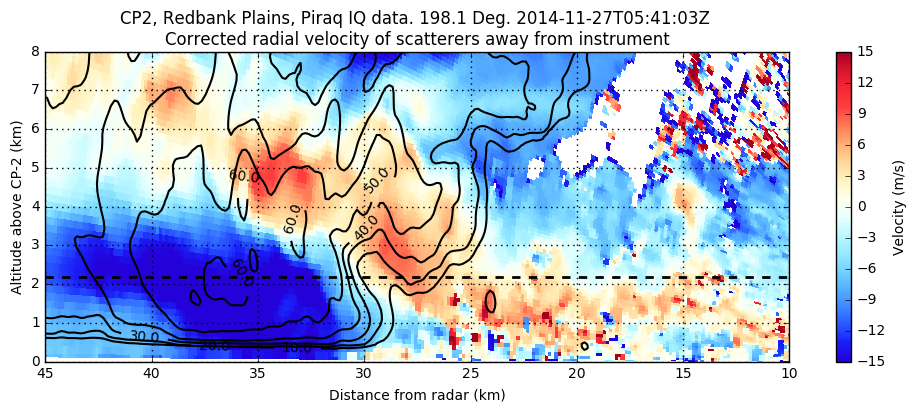

In [34]:
%matplotlib inline

"""
====================================================================
Create an RHI plot with reflectivity contour lines from an MDV file
====================================================================

An example which creates an RHI plot of velocity using a RadarDisplay object
and adding Reflectivity contours from the same MDV file.

"""
print __doc__

# Author: Cory Weber (cweber@anl.gov)
# License: BSD 3 clause
import matplotlib.pyplot as plt
import pyart
import numpy as np
import scipy.ndimage as spyi
from scipy import ndimage

root = '/run/media/meso/DATA/phd/obs/radar/CP2/mdv/s_band/rhi/20141127/'
fn   = '054202.mdv'
ffn  = root + fn

# create the plot using RadarDisplay
sweep = 1
# read file
radar   = pyart.io.read_mdv(ffn)
display = pyart.graph.RadarDisplay(radar)
fig     = plt.figure(figsize=[12, 4])
ax      = fig.add_subplot(111)

# correct for ni
NI       = radar.instrument_parameters['nyquist_velocity']['data'][0]
gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_below('velocity',-20)
gatefilter.exclude_above('velocity',20)
corr_vel = pyart.correct.dealias_region_based(
        radar, vel_field='velocity', keep_original=False, 
        gatefilter = gatefilter, nyquist_vel=NI, centered = True)
radar.add_field('corrected_velocity', corr_vel, replace_existing = True)


start     = radar.get_start(sweep)
end       = radar.get_end(sweep) + 1
vel_data  = radar.fields['corrected_velocity']['data'][start:end]+1
flt_data  = ndimage.median_filter(vel_data, size = 3)
flt_data  = np.ma.masked_where((flt_data == 0) | (flt_data >20) | (flt_data < -20) , flt_data)
radar.fields['corrected_velocity']['data'][start:end] = flt_data

# plot velocity
display.plot('corrected_velocity', sweep=sweep, vmin=-15, vmax=15.0, fig=fig,
             ax=ax, cmap='pyart_BuDRd18', colorbar_label='Velocity (m/s)')
display.set_limits(xlim=[45, 10], ylim=[0, 8])
# line commented out to show reflectivity
# display.plot('reflectivity', sweep=sweep, vmin=-0, vmax=45.0, fig=fig,ax=ax)

# get data
start = radar.get_start(sweep)
end = radar.get_end(sweep) + 1
data = radar.fields['reflectivity']['data'][start:end]

x = radar.gate_x['data'][start:end] / 1000.0 
y = radar.gate_y['data'][start:end] / 1000.0
z = radar.gate_z['data'][start:end] / 1000.0

# smooth out the lines
data = data[10::,:]
x    = x[10::,:]
y    = y[10::,:]
z    = z[10::,:]
data[np.abs(x) < 6] = 0
data[1:2,:] = 0
data = spyi.gaussian_filter(data, sigma=1.2,mode='mirror')

# calculate (R)ange
R = np.sqrt(x ** 2 + y ** 2) * np.sign(y) * np.sign(x)

# add contours
# creates steps 35 to 100 by 5
levels = np.arange(10, 100, 10)
# adds coutours to plot
contours = ax.contour(R, z, data, levels, linewidths=1.5, colors='k',
                      linestyles='solid', antialiased=True)

# adds contour labels (fmt= '%r' displays 10.0 vs 10.0000)
plt.clabel(contours, levels, fmt='%r', inline=True, fontsize=10)


# format plot
# add grid (dotted lines, major axis only)
ax.grid(color='k', linestyle=':', linewidth=1, which='major')

# horizontal
#ax.axhline(1.173, 0, 1, linestyle='solid', color='k', linewidth=2)
ax.axhline(2.168, 0, 1, linestyle='dashed', color='k', linewidth=2)

ax.set_ylabel('Altitude above CP-2 (km)')

plt.show()